# About me:



## Profile
**Name** : BVSG Suraj

**Batch** : 7

**Project** : Implement [Facial Expression Recognition](https://github.com/zlpure/Facial-Expression-Recognition) using winograd convolutions and write a tutorial on the same.

## Current Status

Implementing seperable convolutions.

## Logs
* 21/6 : used kernel_size=5 with data augmentation and class weights. Amazing improvement in performance. (IN PROGRESS)
* 20/6 : Found few valuable observations during the hyperparameter tuning. (DONE)
* 19/6 : Experimenting with hyperparameters. (DONE)
* 18/6 : Ditching Winograd Implementation. Going with Seperable Conv. (DONE)
* 16/6 : Implementing winograd convolutions for 2D data (ABORTTED)
* 14/6 : Performing EDA and some data pre-processing. (DONE)
* 13/6 : Setting up Jupyter Notebook. (DONE)
* 12/6 : Understanding Winograg Convolution. (DONE)
* 10/6 : Starting literature survey. (DONE)

# Preliminary Setup


In [0]:
#Installing required libraries
!pip install -q keras
#!pip install -q --upgrade git+git://github.com/fchollet/keras.git
!pip install -q pathlib

In [2]:
#Linking drive to colab to store datasets
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

Processing triggers for libc-bin (2.26-0ubuntu2.1) ...
Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up gnupg-agent (2.1.15-1ubuntu8.1) ...
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:am

In [3]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

# Generate creds for the Drive FUSE library. Though the link asks you to verify twice, you don't have to!
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [5]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/EIP/Facial_Expression_Recognition/iter_2/

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
Files in Drive:


In [0]:
#Unpack datasets and copy back to drive. Just once at the beginning.
#!tar -xvf drive/EIP/Facial_Expression_Recognition/fer2013.tar.gz
!cp -a drive/EIP/Facial_Expression_Recognition/iter_3/weights-improvement-97-0.58.hdf5 .

# Run this only when starting a new session. Syncing files in drive to pwd.
#!cp -a drive/EIP/Facial_Expression_Recognition/iter_2/*.hdf5 .
#!ls

# Environment specific Setup

In [7]:
#Framework related libraries
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation
from keras.layers import MaxPooling2D, BatchNormalization, SeparableConv2D
from keras.layers import Concatenate
from keras.optimizers import Adam

##---------------------------------------------##

#For loading models
from pathlib import Path
from keras.models import load_model

##---------------------------------------------##

##Data preprocessing

#for class balance
from sklearn.utils import class_weight

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

##---------------------------------------------##

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
#tf.python.control_flow_ops = tf
from keras import backend as k

##---------------------------------------------##

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

##---------------------------------------------##

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [0]:
#Data handling libraries
import numpy as np
import pandas as spd

##---------------------------------------------##

#Image handling libraries
import matplotlib.pyplot as plt

##---------------------------------------------##

# This is a bit of magic to make matplotlib figures appear inline in the notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
%load_ext autoreload
%autoreload 2

# Exploratory Data Analysis



In [0]:
#Given data set is in csv format after unzipping.

file = 'drive/EIP/Facial_Expression_Recognition/fer2013/fer2013.csv'
df = spd.read_csv(file)

In [0]:
#Assign separate data frames to training, cross-validation and test data

#Training set
tr_set = df.loc[df['Usage'] == 'Training']
tr = tr_set.loc[:,'pixels']
tr_labels = tr_set.loc[:,'emotion']

#Cross-validation set
cv_set = df.loc[df['Usage'] == 'PublicTest']
cv = cv_set.loc[:,'pixels']
cv_labels = cv_set.loc[:,'emotion']

#Test set
te_set = df.loc[df['Usage'] == 'PrivateTest']
te = te_set.loc[:,'pixels']
te_labels = te_set.loc[:,'emotion']

Lets randomly sample 5 images of each emotion from training dtaset

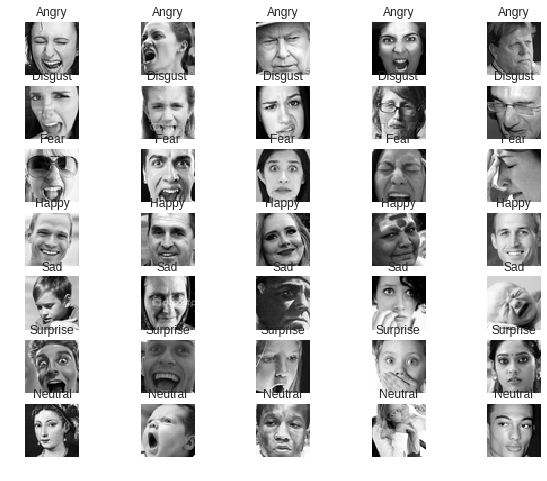

In [11]:
tr_set_emotions_label = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

#size of each class will be stored in this array
t=np.zeros(np.size(tr_set_emotions_label)) 

#No. of images to sample from each class
sample_size=5

#Display those images
for k,e in enumerate(tr_set_emotions_label):
  this_emotion_set = df.loc[(df['Usage'] == 'Training') & (df['emotion'] == k)]
  t[k] = this_emotion_set.size
  x=this_emotion_set.sample(n=sample_size).loc[:,'pixels']
  for i,j in enumerate(x):
    plt.subplot(t.size, sample_size,(sample_size*k)+i+1)
    y = j.split(' ')
    x = np.array(y).reshape(48,48)
    plt.axis('off')
    plt.grid('off')
    plt.imshow(x.astype('uint8'))
    plt.title(e)

## Inferences


1.   The data provided is flattened/unrolled. To display them, we have to roll or reshape the vectors.
2.   This dataset consists of faces of various expressions of all kinds of age, race and sex. That means the data is well generalized. 
3.   Faces in the images seemed to be centered. So, face detection and extraction can be skipped.
4.   Images are in grey scale. That means fewer parameters.
5.  Given the classes 'Surprise' and 'Happy', there might be high chance of misclassification. This is due to their high spatial corelation.

Let's explore data distribution among various classes

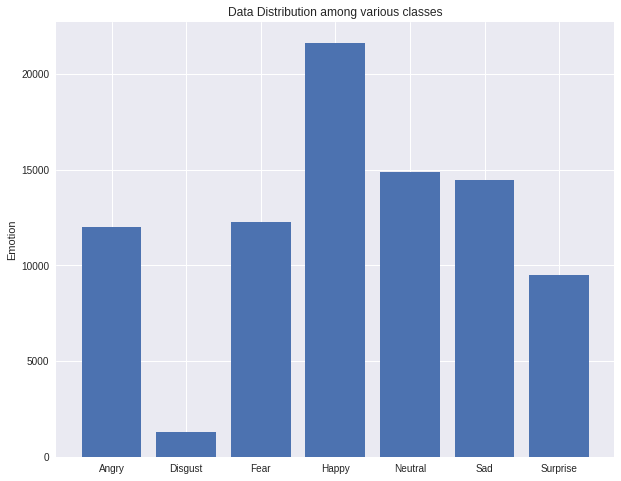

In [12]:
#Plotting no. of training examples vs their class
plt.bar(tr_set_emotions_label, t)
plt.ylabel('No. of training examples')
plt.ylabel('Emotion')
plt.title('Data Distribution among various classes')

plt.show()  

* It can be observed that the class 'Disgust' has very less number of training data. 

* And there is a high possibility of the model to predict 'Happy' if the training data isn't normalized.

* This problem can be solved in various ways:

  1.** Assigning weightage** for each class using Keras 'class_weight'. This is preferred.
  
  2.** Data augmentation** - Since the variation among the no. of training examples accross the classes is very high, using augmentation might not be a good idea. If we do that, there will be a rich variation in 'Happy' class and less variations in 'disgust' class and training over this data would be redundant. But applying Augmentation on all of the classes is a good idea.
  
  3.** Removing data** from other classes. Loss of data is not encouraged usually. 

  4.** Using GANs** : New training data can be created from the respective class's distribution. This is an option too.


**NOTE : The labels on the x-axis are not in order of the labels 0-7**

# Data Preprocessing


## Rolling the data

In [13]:
#train data
tr_img = []
tr_l = np.zeros((np.size(tr),np.size(t)))
#print(tr_labels)
for p,i in enumerate(tr):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    tr_img.append(y)
    tr_l[p,tr_labels[p]]=1
tr_img = np.array(tr_img)
print(tr_img.shape)

(28709, 48, 48, 1)


In [14]:
#cv data
cv_img = []
cv_l = np.zeros((np.size(cv),np.size(t)))
for p,i in enumerate(cv):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    cv_img.append(y)
    cv_l[p,cv_labels[np.size(tr)+p]] = 1
print(cv_l)
cv_img = np.array(cv_img)
print(cv_img.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]
(3589, 48, 48, 1)


In [15]:
#test data
te_img = []
te_l = np.zeros((np.size(te),np.size(t)))
for p,i in enumerate(te):
    y = i.split(' ')
    y = np.array(y).reshape(48,48,1)
    te_img.append(y)
    te_l[p,te_labels[np.size(tr) + np.size(cv) + p]]=1
print(te_l)
te_img = np.array(te_img)
print(te_img.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(3589, 48, 48, 1)


## Assigning weights to classes

In [0]:
#Finding the weightage to be given to each class
class_weights_array = np.round(np.max(t)/t)

class_weight = dict(zip(np.arange(np.size(t)), class_weights_array))

#print(class_weight)

# Data Augmentation

In [17]:
print('Using real-time data augmentation.')

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    horizontal_flip=True) 

datagen.fit(tr_img)
data_aug_x = datagen.flow(tr_img, tr_l, batch_size=64)

Using real-time data augmentation.


# Acrhitecture

## Model

In [41]:
model = Sequential()

f =48
model.add(SeparableConv2D(f,(5,1),activation='relu', input_shape=(48,48,1)))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

##

f=96
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.1))

##

f=198
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.1))

##
'''
f=256
model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(BatchNormalization())

model.add(SeparableConv2D(f,(5,1),activation='relu'))
model.add(SeparableConv2D(f,(1,5),activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Dropout(0.25))
'''
##

model.add(Flatten())
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_37 (Separab (None, 44, 48, 48)        101       
_________________________________________________________________
separable_conv2d_38 (Separab (None, 44, 44, 48)        2592      
_________________________________________________________________
batch_normalization_10 (Batc (None, 44, 44, 48)        192       
_________________________________________________________________
separable_conv2d_39 (Separab (None, 40, 44, 48)        2592      
_________________________________________________________________
separable_conv2d_40 (Separab (None, 40, 40, 48)        2592      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 39, 39, 48)        0         
_________________________________________________________________
separable_conv2d_41 (Separab (None, 35, 39, 96)        4944      
__________

## Compile and run

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint
from keras.callbacks import ModelCheckpoint
filepath= "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

## Epoch 1-10

In [32]:
epoch = 0
model.fit_generator(data_aug_x, 
                    epochs=10,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3

Epoch 1/10
449/449 [==============================] - 94s 209ms/step - loss: 3.1383 - acc: 0.1339 - val_loss: 1.9261 - val_acc: 0.1688

Epoch 00001: val_acc improved from -inf to 0.16885, saving model to weights-improvement-01-0.17.hdf5
Epoch 2/10
177/449 [==========>...................] - ETA: 51s - loss: 3.0982 - acc: 0.1723

449/449 [==============================] - 91s 202ms/step - loss: 3.0474 - acc: 0.1721 - val_loss: 2.5576 - val_acc: 0.1162

Epoch 00002: val_acc did not improve from 0.16885
Epoch 3/10
292/449 [==================>...........] - ETA: 29s - loss: 2.9708 - acc: 0.2004

449/449 [==============================] - 91s 202ms/step - loss: 2.9319 - acc: 0.2150 - val_loss: 1.7657 - val_acc: 0.2884

Epoch 00003: val_acc improved from 0.16885 to 0.28838, saving model to weights-improvement-03-0.29.hdf5
Epoch 4/10
271/449 [=================>............] - ETA: 33s - loss: 2.8788 - acc: 0.2515

449/449 [==============================] - 91s 202ms/step - loss: 2.8471 - acc: 0.2642 - val_loss: 1.8095 - val_acc: 0.2901

Epoch 00004: val_acc improved from 0.28838 to 0.29005, saving model to weights-improvement-04-0.29.hdf5
Epoch 5/10
266/449 [================>.............] - ETA: 34s - loss: 2.7967 - acc: 0.2855

449/449 [==============================] - 91s 202ms/step - loss: 2.7776 - acc: 0.2892 - val_loss: 1.9967 - val_acc: 0.2469

Epoch 00005: val_acc did not improve from 0.29005
Epoch 6/10
319/449 [====================>.........] - ETA: 24s - loss: 2.7247 - acc: 0.3127

449/449 [==============================] - 91s 203ms/step - loss: 2.7061 - acc: 0.3154 - val_loss: 1.8233 - val_acc: 0.2898

Epoch 00006: val_acc did not improve from 0.29005
Epoch 7/10
335/449 [=====================>........] - ETA: 21s - loss: 2.6601 - acc: 0.3353

449/449 [==============================] - 91s 203ms/step - loss: 2.6597 - acc: 0.3353 - val_loss: 1.6206 - val_acc: 0.3789

Epoch 00007: val_acc improved from 0.29005 to 0.37894, saving model to weights-improvement-07-0.38.hdf5
Epoch 8/10
281/449 [=================>............] - ETA: 31s - loss: 2.6042 - acc: 0.3516

449/449 [==============================] - 91s 203ms/step - loss: 2.5824 - acc: 0.3542 - val_loss: 1.6452 - val_acc: 0.3600

Epoch 00008: val_acc did not improve from 0.37894
Epoch 9/10
322/449 [====================>.........] - ETA: 23s - loss: 2.5188 - acc: 0.3695

449/449 [==============================] - 91s 203ms/step - loss: 2.5225 - acc: 0.3725 - val_loss: 1.6965 - val_acc: 0.3435

Epoch 00009: val_acc did not improve from 0.37894
Epoch 10/10
334/449 [=====================>........] - ETA: 21s - loss: 2.4758 - acc: 0.3867

449/449 [==============================] - 91s 202ms/step - loss: 2.4757 - acc: 0.3855 - val_loss: 1.5856 - val_acc: 0.3901

Epoch 00010: val_acc improved from 0.37894 to 0.39008, saving model to weights-improvement-10-0.39.hdf5


## Epoch 11-30

In [36]:
#Didnt use dropout for this layer
model.load_weights('weights-improvement-10-0.39.hdf5')
epoch=10
model.fit_generator(data_aug_x, 
                    epochs=30,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

Epoch 11/30
449/449 [==============================] - 91s 202ms/step - loss: 2.4302 - acc: 0.3986 - val_loss: 1.6574 - val_acc: 0.3722

Epoch 00011: val_acc did not improve from 0.39008
Epoch 12/30
208/449 [============>.................] - ETA: 45s - loss: 2.3938 - acc: 0.4016

449/449 [==============================] - 90s 201ms/step - loss: 2.3894 - acc: 0.4040 - val_loss: 1.5094 - val_acc: 0.4230

Epoch 00012: val_acc improved from 0.39008 to 0.42296, saving model to weights-improvement-12-0.42.hdf5
Epoch 13/30
248/449 [===============>..............] - ETA: 37s - loss: 2.3837 - acc: 0.4131

449/449 [==============================] - 91s 202ms/step - loss: 2.3463 - acc: 0.4176 - val_loss: 1.4536 - val_acc: 0.4450

Epoch 00013: val_acc improved from 0.42296 to 0.44497, saving model to weights-improvement-13-0.44.hdf5
Epoch 14/30
259/449 [================>.............] - ETA: 35s - loss: 2.3075 - acc: 0.4292

449/449 [==============================] - 91s 202ms/step - loss: 2.3148 - acc: 0.4291 - val_loss: 1.6376 - val_acc: 0.3823

Epoch 00014: val_acc did not improve from 0.44497
Epoch 15/30
314/449 [===================>..........] - ETA: 25s - loss: 2.2730 - acc: 0.4362

449/449 [==============================] - 91s 202ms/step - loss: 2.2782 - acc: 0.4378 - val_loss: 1.4914 - val_acc: 0.4344

Epoch 00015: val_acc did not improve from 0.44497
Epoch 16/30
332/449 [=====================>........] - ETA: 21s - loss: 2.2634 - acc: 0.4366

449/449 [==============================] - 91s 202ms/step - loss: 2.2621 - acc: 0.4386 - val_loss: 1.4527 - val_acc: 0.4391

Epoch 00016: val_acc did not improve from 0.44497
Epoch 17/30
338/449 [=====================>........] - ETA: 20s - loss: 2.2191 - acc: 0.4502

449/449 [==============================] - 91s 202ms/step - loss: 2.2196 - acc: 0.4504 - val_loss: 1.4337 - val_acc: 0.4681

Epoch 00017: val_acc improved from 0.44497 to 0.46810, saving model to weights-improvement-17-0.47.hdf5
Epoch 18/30
282/449 [=================>............] - ETA: 31s - loss: 2.2047 - acc: 0.4480

449/449 [==============================] - 91s 202ms/step - loss: 2.2016 - acc: 0.4537 - val_loss: 1.6667 - val_acc: 0.3881

Epoch 00018: val_acc did not improve from 0.46810
Epoch 19/30
323/449 [====================>.........] - ETA: 23s - loss: 2.2085 - acc: 0.4523

449/449 [==============================] - 91s 202ms/step - loss: 2.1979 - acc: 0.4540 - val_loss: 1.3750 - val_acc: 0.4843

Epoch 00019: val_acc improved from 0.46810 to 0.48426, saving model to weights-improvement-19-0.48.hdf5
Epoch 20/30
278/449 [=================>............] - ETA: 32s - loss: 2.1399 - acc: 0.4625

449/449 [==============================] - 91s 202ms/step - loss: 2.1493 - acc: 0.4632 - val_loss: 1.3938 - val_acc: 0.4823

Epoch 00020: val_acc did not improve from 0.48426
Epoch 21/30
321/449 [====================>.........] - ETA: 24s - loss: 2.1367 - acc: 0.4650

449/449 [==============================] - 91s 202ms/step - loss: 2.1509 - acc: 0.4642 - val_loss: 1.5652 - val_acc: 0.3912

Epoch 00021: val_acc did not improve from 0.48426
Epoch 22/30
334/449 [=====================>........] - ETA: 21s - loss: 2.0950 - acc: 0.4712

449/449 [==============================] - 91s 202ms/step - loss: 2.1258 - acc: 0.4670 - val_loss: 1.5723 - val_acc: 0.4171

Epoch 00022: val_acc did not improve from 0.48426
Epoch 23/30
337/449 [=====================>........] - ETA: 21s - loss: 2.0986 - acc: 0.4718

449/449 [==============================] - 91s 202ms/step - loss: 2.1145 - acc: 0.4719 - val_loss: 1.4426 - val_acc: 0.4642

Epoch 00023: val_acc did not improve from 0.48426
Epoch 24/30
339/449 [=====================>........] - ETA: 20s - loss: 2.0747 - acc: 0.4776

449/449 [==============================] - 91s 202ms/step - loss: 2.0744 - acc: 0.4805 - val_loss: 1.4522 - val_acc: 0.4792

Epoch 00024: val_acc did not improve from 0.48426
Epoch 25/30
340/449 [=====================>........] - ETA: 20s - loss: 2.0934 - acc: 0.4812

449/449 [==============================] - 91s 202ms/step - loss: 2.0840 - acc: 0.4801 - val_loss: 1.4836 - val_acc: 0.4500

Epoch 00025: val_acc did not improve from 0.48426
Epoch 26/30
339/449 [=====================>........] - ETA: 20s - loss: 2.0447 - acc: 0.4855

449/449 [==============================] - 91s 202ms/step - loss: 2.0476 - acc: 0.4858 - val_loss: 1.4143 - val_acc: 0.4826

Epoch 00026: val_acc did not improve from 0.48426
Epoch 27/30
340/449 [=====================>........] - ETA: 20s - loss: 2.0295 - acc: 0.4856

449/449 [==============================] - 91s 202ms/step - loss: 2.0326 - acc: 0.4852 - val_loss: 1.4877 - val_acc: 0.4586

Epoch 00027: val_acc did not improve from 0.48426
Epoch 28/30
338/449 [=====================>........] - ETA: 20s - loss: 2.0195 - acc: 0.4925

449/449 [==============================] - 91s 203ms/step - loss: 2.0277 - acc: 0.4898 - val_loss: 1.6888 - val_acc: 0.4143

Epoch 00028: val_acc did not improve from 0.48426
Epoch 29/30
339/449 [=====================>........] - ETA: 20s - loss: 2.0121 - acc: 0.4969

449/449 [==============================] - 91s 202ms/step - loss: 2.0074 - acc: 0.4962 - val_loss: 1.3508 - val_acc: 0.5063

Epoch 00029: val_acc improved from 0.48426 to 0.50627, saving model to weights-improvement-29-0.51.hdf5
Epoch 30/30
281/449 [=================>............] - ETA: 31s - loss: 2.0093 - acc: 0.4945

449/449 [==============================] - 91s 202ms/step - loss: 2.0029 - acc: 0.4970 - val_loss: 1.5496 - val_acc: 0.4205

Epoch 00030: val_acc did not improve from 0.50627


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3

##Epoch 31-50

In [38]:
model.load_weights('weights-improvement-29-0.51.hdf5')
epoch = 30
model.fit_generator(data_aug_x, 
                    epochs=50,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)

Epoch 31/50
449/449 [==============================] - 91s 203ms/step - loss: 1.9873 - acc: 0.4960 - val_loss: 1.4338 - val_acc: 0.4765

Epoch 00031: val_acc did not improve from 0.50627
Epoch 32/50
207/449 [============>.................] - ETA: 45s - loss: 1.9393 - acc: 0.5103

449/449 [==============================] - 91s 203ms/step - loss: 1.9869 - acc: 0.4995 - val_loss: 1.3047 - val_acc: 0.5110

Epoch 00032: val_acc improved from 0.50627 to 0.51101, saving model to weights-improvement-32-0.51.hdf5
Epoch 33/50
247/449 [===============>..............] - ETA: 38s - loss: 1.9379 - acc: 0.5045

449/449 [==============================] - 91s 203ms/step - loss: 1.9601 - acc: 0.5030 - val_loss: 1.3373 - val_acc: 0.5157

Epoch 00033: val_acc improved from 0.51101 to 0.51574, saving model to weights-improvement-33-0.52.hdf5
Epoch 34/50
258/449 [================>.............] - ETA: 35s - loss: 1.9365 - acc: 0.5100

449/449 [==============================] - 91s 203ms/step - loss: 1.9556 - acc: 0.5061 - val_loss: 1.4084 - val_acc: 0.4781

Epoch 00034: val_acc did not improve from 0.51574
Epoch 35/50
315/449 [====================>.........] - ETA: 25s - loss: 1.9264 - acc: 0.5120

449/449 [==============================] - 91s 203ms/step - loss: 1.9266 - acc: 0.5096 - val_loss: 1.2825 - val_acc: 0.5274

Epoch 00035: val_acc improved from 0.51574 to 0.52744, saving model to weights-improvement-35-0.53.hdf5
Epoch 36/50
275/449 [=================>............] - ETA: 32s - loss: 1.9416 - acc: 0.5055

449/449 [==============================] - 91s 203ms/step - loss: 1.9369 - acc: 0.5096 - val_loss: 1.3507 - val_acc: 0.5060

Epoch 00036: val_acc did not improve from 0.52744
Epoch 37/50
319/449 [====================>.........] - ETA: 24s - loss: 1.8919 - acc: 0.5131

449/449 [==============================] - 91s 203ms/step - loss: 1.8939 - acc: 0.5156 - val_loss: 1.3576 - val_acc: 0.4990

Epoch 00037: val_acc did not improve from 0.52744
Epoch 38/50
333/449 [=====================>........] - ETA: 21s - loss: 1.8795 - acc: 0.5148

449/449 [==============================] - 91s 202ms/step - loss: 1.8903 - acc: 0.5162 - val_loss: 1.7247 - val_acc: 0.3773

Epoch 00038: val_acc did not improve from 0.52744
Epoch 39/50
338/449 [=====================>........] - ETA: 20s - loss: 1.8768 - acc: 0.5190

449/449 [==============================] - 91s 202ms/step - loss: 1.8971 - acc: 0.5143 - val_loss: 1.6916 - val_acc: 0.4107

Epoch 00039: val_acc did not improve from 0.52744
Epoch 40/50
339/449 [=====================>........] - ETA: 20s - loss: 1.8798 - acc: 0.5170

449/449 [==============================] - 91s 203ms/step - loss: 1.8792 - acc: 0.5179 - val_loss: 1.4113 - val_acc: 0.4882

Epoch 00040: val_acc did not improve from 0.52744
Epoch 41/50
339/449 [=====================>........] - ETA: 20s - loss: 1.8704 - acc: 0.5233

449/449 [==============================] - 91s 202ms/step - loss: 1.8657 - acc: 0.5219 - val_loss: 1.3143 - val_acc: 0.5261

Epoch 00041: val_acc did not improve from 0.52744
Epoch 42/50
340/449 [=====================>........] - ETA: 20s - loss: 1.8483 - acc: 0.5256

449/449 [==============================] - 91s 202ms/step - loss: 1.8546 - acc: 0.5244 - val_loss: 1.4011 - val_acc: 0.4773

Epoch 00042: val_acc did not improve from 0.52744
Epoch 43/50
339/449 [=====================>........] - ETA: 20s - loss: 1.8338 - acc: 0.5280

449/449 [==============================] - 91s 202ms/step - loss: 1.8484 - acc: 0.5259 - val_loss: 1.4274 - val_acc: 0.4792

Epoch 00043: val_acc did not improve from 0.52744
Epoch 44/50
337/449 [=====================>........] - ETA: 21s - loss: 1.8345 - acc: 0.5288

449/449 [==============================] - 91s 203ms/step - loss: 1.8313 - acc: 0.5290 - val_loss: 1.3399 - val_acc: 0.5166

Epoch 00044: val_acc did not improve from 0.52744
Epoch 45/50
339/449 [=====================>........] - ETA: 20s - loss: 1.8086 - acc: 0.5307

449/449 [==============================] - 91s 202ms/step - loss: 1.8044 - acc: 0.5323 - val_loss: 1.3713 - val_acc: 0.5038

Epoch 00045: val_acc did not improve from 0.52744
Epoch 46/50
340/449 [=====================>........] - ETA: 20s - loss: 1.8061 - acc: 0.5322

449/449 [==============================] - 91s 202ms/step - loss: 1.8137 - acc: 0.5301 - val_loss: 1.3438 - val_acc: 0.5180

Epoch 00046: val_acc did not improve from 0.52744
Epoch 47/50
339/449 [=====================>........] - ETA: 20s - loss: 1.8007 - acc: 0.5370

449/449 [==============================] - 91s 203ms/step - loss: 1.7949 - acc: 0.5360 - val_loss: 1.6023 - val_acc: 0.4068

Epoch 00047: val_acc did not improve from 0.52744
Epoch 48/50
338/449 [=====================>........] - ETA: 20s - loss: 1.7647 - acc: 0.5450

449/449 [==============================] - 91s 203ms/step - loss: 1.7750 - acc: 0.5414 - val_loss: 1.2218 - val_acc: 0.5403

Epoch 00048: val_acc improved from 0.52744 to 0.54026, saving model to weights-improvement-48-0.54.hdf5
Epoch 49/50
280/449 [=================>............] - ETA: 31s - loss: 1.8009 - acc: 0.5338

449/449 [==============================] - 91s 203ms/step - loss: 1.7892 - acc: 0.5375 - val_loss: 1.3674 - val_acc: 0.5007

Epoch 00049: val_acc did not improve from 0.54026
Epoch 50/50
322/449 [====================>.........] - ETA: 23s - loss: 1.7687 - acc: 0.5443

449/449 [==============================] - 91s 202ms/step - loss: 1.7737 - acc: 0.5416 - val_loss: 1.2439 - val_acc: 0.5358

Epoch 00050: val_acc did not improve from 0.54026


In [0]:
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3/

## Epoch 51-70

In [40]:
model.load_weights('weights-improvement-48-0.54.hdf5')
epoch = 50
model.fit_generator(data_aug_x, 
                    epochs=70,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3/

Epoch 51/70
449/449 [==============================] - 91s 202ms/step - loss: 1.7646 - acc: 0.5402 - val_loss: 1.4448 - val_acc: 0.4798

Epoch 00051: val_acc did not improve from 0.54026
Epoch 52/70
207/449 [============>.................] - ETA: 45s - loss: 1.7320 - acc: 0.5449

449/449 [==============================] - 91s 203ms/step - loss: 1.7446 - acc: 0.5424 - val_loss: 1.2840 - val_acc: 0.5417

Epoch 00052: val_acc improved from 0.54026 to 0.54166, saving model to weights-improvement-52-0.54.hdf5
Epoch 53/70
249/449 [===============>..............] - ETA: 37s - loss: 1.7891 - acc: 0.5376

449/449 [==============================] - 91s 203ms/step - loss: 1.7854 - acc: 0.5387 - val_loss: 1.3046 - val_acc: 0.5219

Epoch 00053: val_acc did not improve from 0.54166
Epoch 54/70
312/449 [===================>..........] - ETA: 25s - loss: 1.7379 - acc: 0.5462

449/449 [==============================] - 91s 202ms/step - loss: 1.7468 - acc: 0.5444 - val_loss: 1.4170 - val_acc: 0.4876

Epoch 00054: val_acc did not improve from 0.54166
Epoch 55/70
332/449 [=====================>........] - ETA: 22s - loss: 1.7488 - acc: 0.5469

449/449 [==============================] - 91s 203ms/step - loss: 1.7437 - acc: 0.5485 - val_loss: 1.3082 - val_acc: 0.5249

Epoch 00055: val_acc did not improve from 0.54166
Epoch 56/70
338/449 [=====================>........] - ETA: 20s - loss: 1.7488 - acc: 0.5443

449/449 [==============================] - 91s 202ms/step - loss: 1.7301 - acc: 0.5493 - val_loss: 1.2116 - val_acc: 0.5508

Epoch 00056: val_acc improved from 0.54166 to 0.55085, saving model to weights-improvement-56-0.55.hdf5
Epoch 57/70
281/449 [=================>............] - ETA: 31s - loss: 1.6892 - acc: 0.5610

449/449 [==============================] - 91s 202ms/step - loss: 1.7245 - acc: 0.5534 - val_loss: 1.3610 - val_acc: 0.4987

Epoch 00057: val_acc did not improve from 0.55085
Epoch 58/70
320/449 [====================>.........] - ETA: 24s - loss: 1.7166 - acc: 0.5460

449/449 [==============================] - 91s 203ms/step - loss: 1.7282 - acc: 0.5457 - val_loss: 1.3082 - val_acc: 0.5196

Epoch 00058: val_acc did not improve from 0.55085
Epoch 59/70
333/449 [=====================>........] - ETA: 21s - loss: 1.7022 - acc: 0.5530

449/449 [==============================] - 91s 203ms/step - loss: 1.6988 - acc: 0.5552 - val_loss: 1.2318 - val_acc: 0.5344

Epoch 00059: val_acc did not improve from 0.55085
Epoch 60/70
338/449 [=====================>........] - ETA: 20s - loss: 1.7160 - acc: 0.5529

449/449 [==============================] - 91s 203ms/step - loss: 1.7142 - acc: 0.5527 - val_loss: 1.2646 - val_acc: 0.5447

Epoch 00060: val_acc did not improve from 0.55085
Epoch 61/70
339/449 [=====================>........] - ETA: 20s - loss: 1.6747 - acc: 0.5578

449/449 [==============================] - 91s 203ms/step - loss: 1.6682 - acc: 0.5580 - val_loss: 1.2703 - val_acc: 0.5350

Epoch 00061: val_acc did not improve from 0.55085
Epoch 62/70
338/449 [=====================>........] - ETA: 20s - loss: 1.6763 - acc: 0.5615

449/449 [==============================] - 91s 203ms/step - loss: 1.6892 - acc: 0.5556 - val_loss: 1.5459 - val_acc: 0.4815

Epoch 00062: val_acc did not improve from 0.55085
Epoch 63/70
337/449 [=====================>........] - ETA: 21s - loss: 1.6726 - acc: 0.5663

449/449 [==============================] - 91s 203ms/step - loss: 1.6683 - acc: 0.5673 - val_loss: 1.2741 - val_acc: 0.5520

Epoch 00063: val_acc improved from 0.55085 to 0.55196, saving model to weights-improvement-63-0.55.hdf5
Epoch 64/70
280/449 [=================>............] - ETA: 31s - loss: 1.6467 - acc: 0.5638

449/449 [==============================] - 91s 203ms/step - loss: 1.6590 - acc: 0.5642 - val_loss: 1.3296 - val_acc: 0.5160

Epoch 00064: val_acc did not improve from 0.55196
Epoch 65/70
322/449 [====================>.........] - ETA: 23s - loss: 1.6545 - acc: 0.5633

449/449 [==============================] - 91s 202ms/step - loss: 1.6520 - acc: 0.5620 - val_loss: 1.2564 - val_acc: 0.5330

Epoch 00065: val_acc did not improve from 0.55196
Epoch 66/70
335/449 [=====================>........] - ETA: 21s - loss: 1.6299 - acc: 0.5697

449/449 [==============================] - 91s 203ms/step - loss: 1.6423 - acc: 0.5668 - val_loss: 1.4182 - val_acc: 0.4976

Epoch 00066: val_acc did not improve from 0.55196
Epoch 67/70
338/449 [=====================>........] - ETA: 20s - loss: 1.6359 - acc: 0.5704

449/449 [==============================] - 91s 203ms/step - loss: 1.6445 - acc: 0.5693 - val_loss: 1.2870 - val_acc: 0.5277

Epoch 00067: val_acc did not improve from 0.55196
Epoch 68/70
339/449 [=====================>........] - ETA: 20s - loss: 1.6464 - acc: 0.5638

449/449 [==============================] - 91s 203ms/step - loss: 1.6410 - acc: 0.5657 - val_loss: 1.2387 - val_acc: 0.5514

Epoch 00068: val_acc did not improve from 0.55196
Epoch 69/70
340/449 [=====================>........] - ETA: 20s - loss: 1.6023 - acc: 0.5709

449/449 [==============================] - 91s 203ms/step - loss: 1.6213 - acc: 0.5687 - val_loss: 1.2781 - val_acc: 0.5311

Epoch 00069: val_acc did not improve from 0.55196
Epoch 70/70
340/449 [=====================>........] - ETA: 20s - loss: 1.6245 - acc: 0.5734

449/449 [==============================] - 91s 202ms/step - loss: 1.6448 - acc: 0.5671 - val_loss: 1.2568 - val_acc: 0.5224

Epoch 00070: val_acc did not improve from 0.55196


## Epochs 71-80

In [43]:
model.load_weights('weights-improvement-63-0.55.hdf5')
epoch = 70
model.fit_generator(data_aug_x, 
                    epochs=80,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3/

Epoch 71/80
449/449 [==============================] - 94s 210ms/step - loss: 1.6484 - acc: 0.5652 - val_loss: 1.3410 - val_acc: 0.5116

Epoch 00071: val_acc improved from -inf to 0.51156, saving model to weights-improvement-71-0.51.hdf5
Epoch 72/80
174/449 [==========>...................] - ETA: 52s - loss: 1.5977 - acc: 0.5789

449/449 [==============================] - 92s 204ms/step - loss: 1.6562 - acc: 0.5626 - val_loss: 1.2905 - val_acc: 0.5327

Epoch 00072: val_acc improved from 0.51156 to 0.53274, saving model to weights-improvement-72-0.53.hdf5
Epoch 73/80
239/449 [==============>...............] - ETA: 39s - loss: 1.6354 - acc: 0.5698

449/449 [==============================] - 92s 204ms/step - loss: 1.6569 - acc: 0.5659 - val_loss: 1.2964 - val_acc: 0.5302

Epoch 00073: val_acc did not improve from 0.53274
Epoch 74/80
306/449 [===================>..........] - ETA: 27s - loss: 1.6177 - acc: 0.5738

449/449 [==============================] - 92s 204ms/step - loss: 1.6221 - acc: 0.5731 - val_loss: 1.3700 - val_acc: 0.5082

Epoch 00074: val_acc did not improve from 0.53274
Epoch 75/80
326/449 [====================>.........] - ETA: 23s - loss: 1.6325 - acc: 0.5740

449/449 [==============================] - 92s 205ms/step - loss: 1.6307 - acc: 0.5725 - val_loss: 1.3351 - val_acc: 0.5160

Epoch 00075: val_acc did not improve from 0.53274
Epoch 76/80
331/449 [=====================>........] - ETA: 22s - loss: 1.6383 - acc: 0.5694

449/449 [==============================] - 92s 205ms/step - loss: 1.6268 - acc: 0.5707 - val_loss: 1.2746 - val_acc: 0.5366

Epoch 00076: val_acc improved from 0.53274 to 0.53664, saving model to weights-improvement-76-0.54.hdf5
Epoch 77/80
280/449 [=================>............] - ETA: 32s - loss: 1.6000 - acc: 0.5770

449/449 [==============================] - 92s 205ms/step - loss: 1.6095 - acc: 0.5735 - val_loss: 1.3204 - val_acc: 0.5308

Epoch 00077: val_acc did not improve from 0.53664
Epoch 78/80
319/449 [====================>.........] - ETA: 24s - loss: 1.6013 - acc: 0.5768

449/449 [==============================] - 92s 204ms/step - loss: 1.6070 - acc: 0.5752 - val_loss: 1.2080 - val_acc: 0.5522

Epoch 00078: val_acc improved from 0.53664 to 0.55224, saving model to weights-improvement-78-0.55.hdf5
Epoch 79/80
274/449 [=================>............] - ETA: 33s - loss: 1.5614 - acc: 0.5829

449/449 [==============================] - 92s 205ms/step - loss: 1.5888 - acc: 0.5775 - val_loss: 1.2794 - val_acc: 0.5222

Epoch 00079: val_acc did not improve from 0.55224
Epoch 80/80
318/449 [====================>.........] - ETA: 24s - loss: 1.5887 - acc: 0.5723

449/449 [==============================] - 92s 205ms/step - loss: 1.5955 - acc: 0.5718 - val_loss: 1.1966 - val_acc: 0.5648

Epoch 00080: val_acc improved from 0.55224 to 0.56478, saving model to weights-improvement-80-0.56.hdf5


## Epoch 81-100

In [45]:
model.load_weights('weights-improvement-80-0.56.hdf5')
epoch = 80
model.fit_generator(data_aug_x, 
                    epochs=100,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3/

Epoch 81/100
449/449 [==============================] - 92s 205ms/step - loss: 1.5933 - acc: 0.5769 - val_loss: 1.2578 - val_acc: 0.5497

Epoch 00081: val_acc did not improve from 0.56478
Epoch 82/100
201/449 [============>.................] - ETA: 47s - loss: 1.5621 - acc: 0.5758

449/449 [==============================] - 92s 205ms/step - loss: 1.5782 - acc: 0.5780 - val_loss: 1.4031 - val_acc: 0.5121

Epoch 00082: val_acc did not improve from 0.56478
Epoch 83/100
293/449 [==================>...........] - ETA: 29s - loss: 1.5692 - acc: 0.5794

449/449 [==============================] - 92s 205ms/step - loss: 1.5936 - acc: 0.5755 - val_loss: 1.5082 - val_acc: 0.4617

Epoch 00083: val_acc did not improve from 0.56478
Epoch 84/100
320/449 [====================>.........] - ETA: 24s - loss: 1.5566 - acc: 0.5844

449/449 [==============================] - 92s 205ms/step - loss: 1.5713 - acc: 0.5817 - val_loss: 1.2584 - val_acc: 0.5327

Epoch 00084: val_acc did not improve from 0.56478
Epoch 85/100
330/449 [=====================>........] - ETA: 22s - loss: 1.5733 - acc: 0.5815

449/449 [==============================] - 92s 204ms/step - loss: 1.5662 - acc: 0.5839 - val_loss: 1.2604 - val_acc: 0.5506

Epoch 00085: val_acc did not improve from 0.56478
Epoch 86/100
331/449 [=====================>........] - ETA: 22s - loss: 1.5782 - acc: 0.5863

449/449 [==============================] - 92s 204ms/step - loss: 1.5834 - acc: 0.5850 - val_loss: 1.2079 - val_acc: 0.5584

Epoch 00086: val_acc did not improve from 0.56478
Epoch 87/100
334/449 [=====================>........] - ETA: 21s - loss: 1.5415 - acc: 0.5897

449/449 [==============================] - 92s 204ms/step - loss: 1.5442 - acc: 0.5890 - val_loss: 1.2908 - val_acc: 0.5425

Epoch 00087: val_acc did not improve from 0.56478
Epoch 88/100
328/449 [====================>.........] - ETA: 22s - loss: 1.5255 - acc: 0.5958

449/449 [==============================] - 92s 205ms/step - loss: 1.5307 - acc: 0.5919 - val_loss: 1.2900 - val_acc: 0.5313

Epoch 00088: val_acc did not improve from 0.56478
Epoch 89/100
332/449 [=====================>........] - ETA: 22s - loss: 1.5326 - acc: 0.5914

449/449 [==============================] - 92s 204ms/step - loss: 1.5464 - acc: 0.5862 - val_loss: 1.2799 - val_acc: 0.5400

Epoch 00089: val_acc did not improve from 0.56478
Epoch 90/100
333/449 [=====================>........] - ETA: 22s - loss: 1.5388 - acc: 0.5915

449/449 [==============================] - 92s 205ms/step - loss: 1.5266 - acc: 0.5925 - val_loss: 1.2499 - val_acc: 0.5645

Epoch 00090: val_acc did not improve from 0.56478
Epoch 91/100
334/449 [=====================>........] - ETA: 21s - loss: 1.5209 - acc: 0.5917

449/449 [==============================] - 92s 205ms/step - loss: 1.5075 - acc: 0.5939 - val_loss: 1.2393 - val_acc: 0.5567

Epoch 00091: val_acc did not improve from 0.56478
Epoch 92/100
334/449 [=====================>........] - ETA: 21s - loss: 1.5276 - acc: 0.5909

449/449 [==============================] - 92s 205ms/step - loss: 1.5367 - acc: 0.5897 - val_loss: 1.2106 - val_acc: 0.5584

Epoch 00092: val_acc did not improve from 0.56478
Epoch 93/100
333/449 [=====================>........] - ETA: 22s - loss: 1.5032 - acc: 0.5963

449/449 [==============================] - 92s 204ms/step - loss: 1.5242 - acc: 0.5941 - val_loss: 1.2841 - val_acc: 0.5361

Epoch 00093: val_acc did not improve from 0.56478
Epoch 94/100
332/449 [=====================>........] - ETA: 22s - loss: 1.5332 - acc: 0.5930

449/449 [==============================] - 92s 204ms/step - loss: 1.5299 - acc: 0.5925 - val_loss: 1.2810 - val_acc: 0.5467

Epoch 00094: val_acc did not improve from 0.56478
Epoch 95/100
335/449 [=====================>........] - ETA: 21s - loss: 1.5277 - acc: 0.5907

449/449 [==============================] - 92s 204ms/step - loss: 1.5222 - acc: 0.5898 - val_loss: 1.3724 - val_acc: 0.5247

Epoch 00095: val_acc did not improve from 0.56478
Epoch 96/100
332/449 [=====================>........] - ETA: 22s - loss: 1.5060 - acc: 0.5948

449/449 [==============================] - 92s 204ms/step - loss: 1.5094 - acc: 0.5954 - val_loss: 1.2701 - val_acc: 0.5478

Epoch 00096: val_acc did not improve from 0.56478
Epoch 97/100
334/449 [=====================>........] - ETA: 21s - loss: 1.4726 - acc: 0.6029

449/449 [==============================] - 92s 205ms/step - loss: 1.4684 - acc: 0.6019 - val_loss: 1.2008 - val_acc: 0.5651

Epoch 00097: val_acc improved from 0.56478 to 0.56506, saving model to weights-improvement-97-0.57.hdf5
Epoch 98/100
278/449 [=================>............] - ETA: 32s - loss: 1.4604 - acc: 0.6024

449/449 [==============================] - 92s 205ms/step - loss: 1.4821 - acc: 0.6008 - val_loss: 1.2021 - val_acc: 0.5692

Epoch 00098: val_acc improved from 0.56506 to 0.56924, saving model to weights-improvement-98-0.57.hdf5
Epoch 99/100
260/449 [================>.............] - ETA: 35s - loss: 1.4785 - acc: 0.6030

449/449 [==============================] - 92s 204ms/step - loss: 1.4833 - acc: 0.6014 - val_loss: 1.2520 - val_acc: 0.5612

Epoch 00099: val_acc did not improve from 0.56924
Epoch 100/100
307/449 [===================>..........] - ETA: 26s - loss: 1.4746 - acc: 0.6074

449/449 [==============================] - 92s 205ms/step - loss: 1.4889 - acc: 0.6039 - val_loss: 1.2082 - val_acc: 0.5614

Epoch 00100: val_acc did not improve from 0.56924


## Epoch 101-120

In [54]:
model.load_weights('weights-improvement-98-0.57.hdf5')
epoch = 100
model.fit_generator(data_aug_x, 
                    epochs=120,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_3/

OSError: ignored

## Epochs 100-120

In [0]:
lr=0.0003
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# checkpoint
from keras.callbacks import ModelCheckpoint
filepath= "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

model.load_weights('weights-improvement-97-0.58.hdf5')
epoch = 100
model.fit_generator(data_aug_x, 
                    epochs=120,
                    verbose=1,
                    initial_epoch=epoch,
                    callbacks=callbacks_list,
                    validation_data=(cv_img, cv_l),
                    class_weight = class_weight)
!cp *.hdf5 drive/EIP/Facial_Expression_Recognition/iter_4/

Epoch 101/120
449/449 [==============================] - 96s 214ms/step - loss: 1.4068 - acc: 0.6223 - val_loss: 1.2775 - val_acc: 0.5542

Epoch 00101: val_acc improved from -inf to 0.55419, saving model to weights-improvement-101-0.55.hdf5
Epoch 102/120
162/449 [=========>....................] - ETA: 54s - loss: 1.4498 - acc: 0.6094

449/449 [==============================] - 92s 204ms/step - loss: 1.4203 - acc: 0.6174 - val_loss: 1.2378 - val_acc: 0.5673

Epoch 00102: val_acc improved from 0.55419 to 0.56729, saving model to weights-improvement-102-0.57.hdf5
Epoch 103/120
235/449 [==============>...............] - ETA: 40s - loss: 1.4554 - acc: 0.6118

449/449 [==============================] - 91s 204ms/step - loss: 1.4227 - acc: 0.6160 - val_loss: 1.2466 - val_acc: 0.5729

Epoch 00103: val_acc improved from 0.56729 to 0.57286, saving model to weights-improvement-103-0.57.hdf5
Epoch 104/120
253/449 [===============>..............] - ETA: 37s - loss: 1.3720 - acc: 0.6252

449/449 [==============================] - 92s 204ms/step - loss: 1.3816 - acc: 0.6236 - val_loss: 1.3446 - val_acc: 0.5344

Epoch 00104: val_acc did not improve from 0.57286
Epoch 105/120
310/449 [===================>..........] - ETA: 26s - loss: 1.4065 - acc: 0.6229

315/449 [====================>.........] - ETA: 25s - loss: 1.4087 - acc: 0.6225

## Testing phase

In [62]:
model.load_weights('weights-improvement-113-0.58.hdf5')
score = model.evaluate(te_img,te_l, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
#model.save_weights("DNST_model.h5")
print("Saved model to disk")

3589/3589 [==============================] - 8s 2ms/step
Test loss: 1.1628494354037064
Test accuracy: 0.5971022569292865
Saved model to disk


In [57]:
!ls

datalab				   weights-improvement-112-0.58.hdf5
drive				   weights-improvement-113-0.58.hdf5
weights-improvement-101-0.55.hdf5  weights-improvement-118-0.58.hdf5
weights-improvement-102-0.57.hdf5  weights-improvement-97-0.58.hdf5
weights-improvement-103-0.57.hdf5
